## Quality Assurance and YAML Creator for Hathi Trust
2018, Jeremy D Moore

This notebook is used for quality assurance of images and create a YAML file in accordance with Hathi Trust's standards.

Access date 2018-12-05:
https://www.hathitrust.org/deposit_guidelines

Hathi Trust guidelines in Google Docs linked from above:
https://docs.google.com/document/d/1OQ0SKAiOH8Xi0HVVxg4TryBrPUPtdv4qA70d8ghRltU/view

meta.yml.example.txt linked from above guidelines in Google Docs: https://drive.google.com/file/d/0B0EHs5JWGUMLWjU2OHVhQzN5WEk/view

(Note: Jeremy downloaded copies of the above to his Google Drive for reference)

## Content

From HathiTrust Cloud Validation and Packaging Service (referenced as "guidelines above")

Item: 1 book or serial
- Each item must be in a .zip named with the Object ID
  - zip contents should be flat
- checksum.md5
- meta.yml

Per page
 - 1 image named with sequential 8-digit filename
      - ex: 00000001.tif or 00000001.jp2
      - bitonal specs
        - File: TIFF
        - Compression: Group4
        - PPI: 600
        - Bit Depth: 1
        - Photometric Interpretation: WhiteIsZero
      - continuous tone specs
        - File: JPEG2000
        - Compression: Kakadu Part 1 lossy
        - PPI: 300
        - Bit Depth: 8
        - Color Space: sRGB (but NO embedded profile!)
        - Decomposition Levels: b/w 5 & 32
 - 1 OCR plain text UTF-8 with same stem as image file
   - ex: 00000001.txt
 - 1 hOCR location file with same stem as image file
   - .xml or .html
   - ex: 00000001.html

## meta.yml File Creation

Necessary information:
- object ID
  - used as the .zip file's name
  - added to each image's metadata as DocumentName / dc:source
- capture date
  - approximate date and time the volume scanned
  - used for the PREMIS capture event
  - "ModifyDate TIFF header" that I can't find
    - add link to spec
  - XMP tiff:DateTime metadata
    - add link to spec
  - Must be in ISO8601 combined date format with time zone
  - ex: 2013-11-01T12:31:00-05:00
- scanner make
  - XMP tiff:Make metadata
    - add link to spec
- scanner model
  - XMP tiff:Model metadata
    - add link to spec
- scanner user
  - "It should reflect 'who pushed the button' to actually scan the item. This could be an organizational unit or an outside vendor." -- meta.yml.example.txt
  - TIFF Artist
    - https://www.awaresystems.be/imaging/tiff/tifftags/artist.html
  - XMP tiff:Artist
    - add link to spec
- bitonal resolution dpi
  - 600+
- contone resolution dpi
  - 300+
- image compression date
  - "If images were compressed, converted, or normalized before SIP generation, these values should be supplied." -- meta.yml.example.txt
  - date must be in ISO8601 format as above capture date
- image compression agent
  - HathiTrust organization code
- image compression tool
  - "The tools should list the software tool names and versions." -- meta.yml.example.txt
- scanning_order
  - left-to-right
- reading order
  - left-to-right
- pagedata
  - Possible page tags:
    - BACK_COVER
    - BLANK
    - CHAPTER_PAGE
    - CHAPTER_START
       - also used for beginning of each appendix
    - COPYRIGHT
    - FIRST_CONTENT_CHAPTER_START
    - FOLDOUT
    - FRONT_COVER
    - IMAGE_ON_PAGE
    - INDEX
    - MULTIWORK_BOUNDARY
    - PREFACE
    - REFERENCES
    - TABLE_OF_CONTENTS
    - TITLE
    - TITLE_PARTS
   - order label is the page number and the label is the page tag
   - multiple page tags should be comma-separated

# 1. Load Imports & Options

In [5]:
# Imports & Options
%matplotlib inline

# built-in
import logging
import shutil
import sys
from pathlib import Path

# 3rd party
from ipywidgets import IntProgress, Label, VBox
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image

# local imports
import img_qc.exiftool as exiftool

# parameters for matplotlib to increase our default figure size -- NOTE: figure sizes are in INCHES
plt.rcParams["figure.figsize"] = (12,12)  # set as needed for your screen and eyes

# on a high-dpi monitor this will increase the quality of plots on-screen
%config InlineBackend.figure_format = 'retina'

# set max_colwidth for a wider column so data isn't truncated
pd.set_option('display.max_colwidth', -1)  # won't truncate output such as Path names

# set Logging Configuration with current level at INFO
logging.basicConfig(format='%(message)s', level=logging.INFO, stream=sys.stdout)

# == display 90% width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# 2. Load Functions

In [6]:
# Functions

def print_logging_error(error_text_as_list):
    '''
    Spits out logging error
    '''
    logging.error('')
    logging.error(f'*****************START*ERROR***START*ERROR*********************')
    logging.error('')
    for line in error_text_as_list:
        logging.error(line)
    logging.error('')
    logging.error(f'*******************END*ERROR***END*ERROR***********************')
    logging.error('')
    return


def check_hathitrust_image_filenames(image_directory, image_extension):
    '''
    Check that directory name is the object_id
    Make sure image filenames start @ 00000001.tif and go up to len(image_paths_list)
    '''
    image_directory_path = Path(image_directory)
    
    if not image_directory_path.is_dir():
        print_logging_error([f'Problem: {image_directory_path.name} does NOT exist!',
                             f'Remediation: check image_directory Path and re-run'
                            ]
                           )
        return
    
    wrong_directory_name = False
    
    if image_directory_path.name != str(object_id):  # cast object_id as str because we are using barcodes
        wrong_directory_name = True
        error_text_as_list = [f'Problem: image_directory name "{image_directory_path.name}" does NOT match object_id "{object_id}"',
                              f'Remediation: Rename directory & contents with "image_directory = rename_hathitrust_directory_before_ocr(image_directory, object_id)"'
                             ]
        print_logging_error(error_text_as_list)
        
    image_paths_list = sorted(image_directory_path.glob('*' + image_extension))
    number_of_images = len(image_paths_list)
    if number_of_images == 0:
        #error_text_as_list = [f'image_directory "{image_directory_path.name}" contains 0 "{image_extension}"',
        #                      f'No images to process'
        #                     ]
        print_logging_error([f'Problem: image_directory "{image_directory_path.name}" contains 0 "{image_extension}"',
                            f'Remediation: Change image_directory to path with images'
                            ]
                           )
        return
        
    
    logging.info(f'Directory: {image_directory}')
    logging.info(f'Number of {image_extension}: {number_of_images}')
    logging.info(f'First filename: {image_paths_list[0].name}')
    logging.info(f'Last filename: {image_paths_list[-1].name}')
    
    # progress bar
    label = f'Checking for existence of images in {image_directory_path.name}'
    progress_label = Label(label)
    progress_bar = IntProgress(min=0, max=number_of_images)
    progress_widget = VBox([progress_label, progress_bar])
    display(progress_widget)
    
    number_of_naming_errors = 0

    # check that each possible files is correctly numbered starting with 1
    for number in range(number_of_images):
        
        # create name and path to test against image_path
        name_to_test = str(number + 1).zfill(8) + image_extension  # add 1 to number for filename
        
        # set Progress Bar label
        label = f'Checking for existence of "{name_to_test}"'
        progress_label.value = label
        
        path_to_test = image_directory_path.joinpath(name_to_test)
        image_path = image_paths_list[number]
        
        if path_to_test != image_path:  # sorted list of filenames is incorrect, but file may still exist
            if not path_to_test.is_file():
                number_of_naming_errors += 1
            else:
                logging.critical(f'{name_to_test} exists, but does not match {image_path.name} -- investigate manually')
                return 
            
        # update progress bar
        progress_bar.value = number + 1  # add 1 to number so we count when the image is done
    
    if number_of_naming_errors > 0:
        logging.error(f'*** {image_directory_path.name} is NOT named for HathiTrust ***')
        if number_of_naming_errors == number_of_images:
            print_logging_error
            logging.error('')
            logging.error(f'*****************START*ERROR***START*ERROR*********************')
            logging.error(f'Number of images ({number_of_images}) equals total number of naming errors ({number_of_naming_errors})')
            logging.error('Try renaming by running "rename_hathitrust_directory_before_ocr(image_directory, image_extension)"')
            logging.error(f'*******************END*ERROR***END*ERROR***********************')
            logging.error('')
            return
        else:
            logging.error('')
            logging.error(f'*****************START*ERROR***START*ERROR*********************')
            logging.error(f'There were {number_of_naming_errors} naming errors in {number_of_images} {image_extension} filenames -- investigate manually')
            logging.error(f'*******************END*ERROR***END*ERROR***********************')
            logging.error('')
            return
        
    if wrong_directory_name:
        logging.info(f'All {number_of_images} {image_extension} filenames SUCCESSFULLY checked BUT Image Directory Name is WRONG') 
    else:
        logging.info(f'All {number_of_images} {image_extension} filenames SUCCESSFULLY checked') 
    return


def get_formatted_extension(from_extension, remediate=False):
    """-- Purpose --
    Return an extension that:
    1. has a period in the front
    2. Optional: is lower-case
    3. Optional: return jpeg as jpg and tiff as tif
    
    -- Arguments --
    from_extension: file extension with or without a '.'
    
    -- Returns --
    formatted_extension: type=string; formatted extension"""
    
    # make sure there's a period at the front of the extension
    if from_extension.startswith('.'):
        
        # do nothing
        formatted_extension = from_extension
        
    else:  # add a period
        formatted_extension = ('.' + from_extension)
    
    # make it lower-case
    if remediate:
        formatted_extension = formatted_extension.lower()
        # alter jpeg and tiff
        if formatted_extension == '.jpeg':
            formatted_extension = '.jpg'
        elif formatted_extension == '.tiff':
            formatted_extension = '.tif'

    return formatted_extension
    
    
def get_images_df(image_directory, image_extension):
    """--- Purpose ---
    1. Get metadata for all files with image_extension in image_directory with ExifTool (including sub-folders)
    2. Return dataframe for further analysis
    
    --- Arguments ---
    image_directory: root directory to start looking for images with image_extension
    image_extension: image extension to search in image_directory for
    
    --- Return ---
    images_dataframe: pandas dataframe including all images with image_extension"""
    
    
    image_directory_path = Path(image_directory)
    
    image_paths_list = list(image_directory_path.glob('**/*' + image_extension))
    
    image_paths_strings_list = sorted([str(x) for x in image_paths_list])  # need list of strings, not Path objects
    
    # get metadata using pyexiftool    
    with exiftool.ExifTool() as et:
        exiftool_metadata = et.get_metadata_batch(image_paths_strings_list)
    
    # convert exiftool metadata into pandas DataFrame
    images_df = pd.DataFrame(exiftool_metadata)
    
    return images_df


def rename_hathitrust_volume_before_ocr(image_directory, image_extension):
    
    # get total number of and the image paths for images to rename
    image_directory_path = Path(image_directory)
    image_paths_list = sorted(image_directory_path.glob('*' + image_extension))
    number_of_images = len(image_paths_list)
    
    # backup image_directory before renaming
    backup_directory_name = image_directory_path.name + '_backup'
    backup_directory_path = image_directory_path.parents[0].joinpath(backup_directory_name)
    
    if backup_directory_path.exists():  # shutil.copytree below requires target directory NOT exist
        shutil.rmtree(backup_directory_path)
        
    shutil.copytree(image_directory_path, backup_directory_path)
    
    if backup_directory_path.exists():
        logging.info(f'Backup image directory created at {backup_directory_path}')
        
    # create new directory with correct object_id
    if Path(image_directory).name != str(object_id):
        object_id_directory_path = Path(image_directory).parents[0].joinpath(str(object_id))
        try: 
            object_id_directory_path.mkdir()
        except FileExistsError:
            logging.warning('')
            logging.warning(f'*****')
            logging.warning(f'Warning: {object_id_directory_path} already exists, will rename files in place')
            object_id_directory_path = image_directory_path
            logging.warning(f'*****')
            logging.warning('')
            
    else:
        object_id_directory_path = image_directory_path
    
    logging.info(f'Renaming {number_of_images} {image_extension} images in {image_directory} for HathiTrust')
    image_extension_original = image_extension
    image_extension = get_formatted_extension(image_extension, remediate=True)
    if image_extension != image_extension_original:
        logging.info(f'Remediation necessary: {image_extension_original} -> {image_extension}')    
    logging.info(f'Images will be renamed 00000001.extension - {str(number_of_images).zfill(8) + image_extension}')
    
    # rename images
    for number in range(number_of_images):
        
        image_path_to_rename = image_paths_list[number]
        
        new_image_name = str(number + 1).zfill(8) + image_extension  # add 1 to number for filename
        new_image_path = object_id_directory_path.joinpath(new_image_name)
        
        image_path_to_rename.rename(new_image_path)
        
    logging.info('')
    logging.info('Checking renamed files with "check_hathitrust_image_filenames(image_directory, image_extension)"')
    check_hathitrust_image_filenames(object_id_directory_path, image_extension)
    
    
    # DELETE EMPTY DIRECTORY AFTER RENAMING
    if len(list(image_directory_path.iterdir())) == 0:
        image_directory_path.rmdir()
    
    logging.info('')
    logging.info(f"INFO: the new 'imaging_directory' to continue processing this volume is located at {object_id_directory_path}")
    
    # return new object_id directory to be used as image_directory
    # and the image_extension used to rename
    return str(object_id_directory_path), image_extension

In [7]:
exten1 = get_formatted_extension('TIFF')
exten2 = get_formatted_extension('TIFF', remediate=True)

exten1, exten2

('.TIFF', '.tif')

# 3. Update Technical Metadata

In [8]:
# Technical Metadata

# individual object and institution info to verify
object_id = '000000000001'  # we are using the barcode, but doing testing with Reavis_Without_Documents
scanner_user = 'University of Tennessee: John C. Hodges Library'  # Wrong
scanning_order = 'left-to-right'
reading_order = 'left-to-right'

# capture info to verify
capture_date = '2019-01-01T12:00:00-5:00'  # Wrong
scanner_make = 'Fujitsu'  # WRONG
scanner_model = '6670-fi'  # WRONG

# processing info to verify
bitonal_resolution_dpi = 600  # HathiTrust min bitonal dpi: 600
contone_resolution_dpi = 300  # HathiTrust min contone dpi: 300
image_compression_date = '2019-02-12T12:00:00-5:00'  # Wrong
image_compression_agent = 'utk'  # HathiTrust organization code
image_compression_tool: ['Pillow v.5.4.1']  # Assumes use of Python/Pillow for compression, check version number

# 4. Update Directory Path

In [11]:
# image_directory = 'data/PapersOfAndrewJackson/01_tif/PapersOfAndrewJackson_v1'
image_directory = 'data/Reavis_Without_Documents/'

# 5. Check Directory and Image Names

In [12]:
# check directory and image names

image_extension = get_formatted_extension('tif')  # only works with TIFF directories right now

check_hathitrust_image_filenames(image_directory, image_extension)


*****************START*ERROR***START*ERROR*********************

Problem: image_directory name "Reavis_Without_Documents" does NOT match object_id "000000000001"
Remediation: Rename directory & contents with "image_directory = rename_hathitrust_directory_before_ocr(image_directory, object_id)"

*******************END*ERROR***END*ERROR***********************

Directory: data/Reavis_Without_Documents/
Number of .tif: 300
First filename: Reavis_Without_Documents_0001.tif
Last filename: Reavis_Without_Documents_0300.tif


*** Reavis_Without_Documents is NOT named for HathiTrust ***

*****************START*ERROR***START*ERROR*********************
Number of images (300) equals total number of naming errors (300)
Try renaming by running "rename_hathitrust_directory_before_ocr(image_directory, image_extension)"
*******************END*ERROR***END*ERROR***********************



# 5a. Rename Images for HathiTrust

In [13]:
image_directory, image_extension = rename_hathitrust_volume_before_ocr(image_directory, image_extension)
image_directory

Backup image directory created at data/Reavis_Without_Documents_backup
Renaming 300 .tif images in data/Reavis_Without_Documents/ for HathiTrust
Images will be renamed 00000001.extension - 00000300.tif

Checking renamed files with "check_hathitrust_image_filenames(image_directory, image_extension)"
Directory: data/000000000001
Number of .tif: 300
First filename: 00000001.tif
Last filename: 00000300.tif


All 300 .tif filenames SUCCESSFULLY checked

INFO: the new 'imaging_directory' to continue processing this volume is located at data/000000000001


'data/000000000001'

## Check Images for HathiTrust

In [ ]:
# can I get the necessary metadata I need from Pillow for HathiTrust?

# split images at: bitonal/contone is bitspersample -> 1/1+
# bitonal: format -> TIFF
# bitonal: photometric_interpretation -> 0
# bitonal: x_ and y_ resolution -> 600
# bitonal: compression -> Group4
# if bitonal passes add to OCR list
# if bitonal doens't pass -> remediate
# contone: format -> JPEG2000
# contone: compression -> Kakadu Part 1 Lossy
# contone: bit depth -> 8
# contone: colorspace sRGB *NOTE: icc not embedded
# 

In [14]:
images_df = get_images_df(image_directory, image_extension)

In [28]:
bitonal_df = images_df[images_df['EXIF:BitsPerSample'] == 1].dropna(axis='columns', how='all')  # drop columns that are all NaN values
if len(bitonal_df) == 0:
    print('No bitonal images')
else:
    print(f'{len(bitonal_df)} bitonal images')
    bitonal_errors_compression_df = bitonal_df[bitonal_df['EXIF:Compression'] != 4]  # bitonal images without group4 compression
    if len(bitonal_errors_compression_df) > 0:
        bitonal_errors = True
    bitonal_errors_resolution_unit_df = bitonal_df[bitonal_df['EXIF:ResolutionUnit'] != 2]  # in TIFF is 2 for inches, 1 is inches in JPEG
    if len(bitonal_errors_resolution_unit_df) > 0:
        bitonal_errors = True

contone_df = images_df[images_df['EXIF:BitsPerSample'] != 1].dropna(axis='columns', how='all')
if len(contone_df) == 0:
    print('No contone images')
else:
    print(f'{len(contone_df)} contone images')

290 bitonal images
10 contone images


## Save images as Photometric_Interpretation = 0

In [31]:
min_is_black_df = bitonal_df[bitonal_df['EXIF:PhotometricInterpretation'] == 1].dropna(axis='columns', how='all')

## Save bitonal as white-is-min using Pillow and no ImageMagick or Exiftool dependancy!

Though I am still using imagemagick to check the Photometric Interpretation in the following cell
and Exiftool is still being used to create the Dataframes, but this could be adjusted to just use Pillow . . . maybe?

In [41]:
# invert image with numpy then save with Photometric Interpretation of 0, or white-is-min

# convert black-is-min TIFFs to white-is-min
min_is_black_df = bitonal_df[bitonal_df['EXIF:PhotometricInterpretation'] == 1]

for image in min_is_black_df['SourceFile']:
    image_path = Path(image)
    logging.debug(f'Image: {image_path.name}')
    photometric_interpretation = !magick {image_path} -format "%[tiff:photometric]" info:
    logging.debug(f'Before: {photometric_interpretation}')
    image_array_inverted = np.invert(np.array(Image.open(image_path)))
    image_inverted = Image.fromarray(image_array_inverted)
    # save with Jeremy's patched version of Pillow 5.4.1's TiffImagePlugin.py
    image_inverted.save(image_path, compression='group4', dpi=(600., 600.), photometric_interpretation=(0,))
    photometric_interpretation = !magick {image_path} -format "%[tiff:photometric]" info:
    logging.debug(f'After: {photometric_interpretation}')

## Check all min_is_black_df TIFFs for Photometric Interpretation

In [43]:
# check photometric interpretation using Pillow
for image in min_is_black_df['SourceFile']:
    image_path = Path(image)
    image = Image.open(image_path)
    print(f'{image_path.name} PhotoInterp: {image.tag_v2[262]}')

00000002.tif PhotoInterp: 0
00000006.tif PhotoInterp: 0
00000008.tif PhotoInterp: 0
00000012.tif PhotoInterp: 0
00000018.tif PhotoInterp: 0
00000026.tif PhotoInterp: 0
00000038.tif PhotoInterp: 0
00000062.tif PhotoInterp: 0
00000072.tif PhotoInterp: 0
00000078.tif PhotoInterp: 0
00000080.tif PhotoInterp: 0
00000092.tif PhotoInterp: 0
00000150.tif PhotoInterp: 0
00000156.tif PhotoInterp: 0
00000190.tif PhotoInterp: 0
00000196.tif PhotoInterp: 0
00000218.tif PhotoInterp: 0
00000230.tif PhotoInterp: 0
00000232.tif PhotoInterp: 0
00000256.tif PhotoInterp: 0
00000299.tif PhotoInterp: 0


## Check all bitonal files to make sure they are White-Is-Min

In [44]:
count = 0
for image in bitonal_df['SourceFile']:
    image_path = Path(image)
    image = Image.open(image_path)
    if image.tag_v2[262] != 0:
        print(f'{image_path.name} NOT White-Is-Min')
    else:
        count += 1
print(f'correct images/total images')
print(f'{count}/{len(bitonal_df)}')

correct images/total images
290/290


In [51]:
from PIL import TiffTags
dir(TiffTags)

['ASCII',
 'BYTE',
 'DOUBLE',
 'FLOAT',
 'LIBTIFF_CORE',
 'LONG',
 'RATIONAL',
 'SHORT',
 'SIGNED_BYTE',
 'SIGNED_LONG',
 'SIGNED_RATIONAL',
 'SIGNED_SHORT',
 'TAGS',
 'TAGS_V2',
 'TYPES',
 'TagInfo',
 'UNDEFINED',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_populate',
 'lookup',
 'namedtuple']

In [81]:
# what are the tags we need to identify?
for tag in TiffTags.TAGS_V2:
    print(TiffTags.lookup(tag))

TagInfo(value=254, name='NewSubfileType', type=4, length=1, enum={})
TagInfo(value=255, name='SubfileType', type=3, length=1, enum={})
TagInfo(value=256, name='ImageWidth', type=4, length=1, enum={})
TagInfo(value=257, name='ImageLength', type=4, length=1, enum={})
TagInfo(value=258, name='BitsPerSample', type=3, length=0, enum={})
TagInfo(value=259, name='Compression', type=3, length=1, enum={'Uncompressed': 1, 'CCITT 1d': 2, 'Group 3 Fax': 3, 'Group 4 Fax': 4, 'LZW': 5, 'JPEG': 6, 'PackBits': 32773})
TagInfo(value=262, name='PhotometricInterpretation', type=3, length=1, enum={'WhiteIsZero': 0, 'BlackIsZero': 1, 'RGB': 2, 'RGB Palette': 3, 'Transparency Mask': 4, 'CMYK': 5, 'YCbCr': 6, 'CieLAB': 8, 'CFA': 32803, 'LinearRaw': 32892})
TagInfo(value=263, name='Threshholding', type=3, length=1, enum={})
TagInfo(value=264, name='CellWidth', type=3, length=1, enum={})
TagInfo(value=265, name='CellLength', type=3, length=1, enum={})
TagInfo(value=266, name='FillOrder', type=3, length=1, enum

In [ ]:
# get all bitonal images
from PIL import ExifTags

exifData = {}
img = Image.open(picture.jpg)
exifDataRaw = img._getexif()
for tag, value in exifDataRaw.items():
    decodedTag = ExifTags.TAGS.get(

In [ ]:
# get exifData for all images

In [ ]:
# maybe I just need to loop through all of the images
# as each image is processed the metadata is updated

# loop through images displaying data and output

In [106]:
image_directory

'data/000000000001'

In [105]:
image_extension

'.tif'

In [114]:
image_paths_list = sorted((Path(image_directory).glob('*' + image_extension)))
image_paths_list

[PosixPath('data/000000000001/00000001.tif'),
 PosixPath('data/000000000001/00000002.tif'),
 PosixPath('data/000000000001/00000003.tif'),
 PosixPath('data/000000000001/00000004.tif'),
 PosixPath('data/000000000001/00000005.tif'),
 PosixPath('data/000000000001/00000006.tif'),
 PosixPath('data/000000000001/00000007.tif'),
 PosixPath('data/000000000001/00000008.tif'),
 PosixPath('data/000000000001/00000009.tif'),
 PosixPath('data/000000000001/00000010.tif'),
 PosixPath('data/000000000001/00000011.tif'),
 PosixPath('data/000000000001/00000012.tif'),
 PosixPath('data/000000000001/00000013.tif'),
 PosixPath('data/000000000001/00000014.tif'),
 PosixPath('data/000000000001/00000015.tif'),
 PosixPath('data/000000000001/00000016.tif'),
 PosixPath('data/000000000001/00000017.tif'),
 PosixPath('data/000000000001/00000018.tif'),
 PosixPath('data/000000000001/00000019.tif'),
 PosixPath('data/000000000001/00000020.tif'),
 PosixPath('data/000000000001/00000021.tif'),
 PosixPath('data/000000000001/0000

In [ ]:
for image_path in image_paths_list:
    

In [82]:
from PIL import ExifTags
exifData = {}

In [86]:
image = Image.open('/Users/jeremy/rgb_text_test_image_photoshop_save.tif')
image.show()

In [96]:
for tag in image.tag:
    for tag2 in image.tag_v2:
        if tag == tag2:
            print(tag, 'in both')

256 in both
257 in both
258 in both
259 in both
262 in both
273 in both
274 in both
277 in both
278 in both
279 in both
282 in both
283 in both
284 in both
296 in both
305 in both
306 in both
700 in both
34377 in both
34665 in both
254 in both


In [97]:
for tag in image.tag_v2:
    print(tag)
    print(TiffTags.lookup(tag))

256
TagInfo(value=256, name='ImageWidth', type=4, length=1, enum={})
257
TagInfo(value=257, name='ImageLength', type=4, length=1, enum={})
258
TagInfo(value=258, name='BitsPerSample', type=3, length=0, enum={})
259
TagInfo(value=259, name='Compression', type=3, length=1, enum={'Uncompressed': 1, 'CCITT 1d': 2, 'Group 3 Fax': 3, 'Group 4 Fax': 4, 'LZW': 5, 'JPEG': 6, 'PackBits': 32773})
262
TagInfo(value=262, name='PhotometricInterpretation', type=3, length=1, enum={'WhiteIsZero': 0, 'BlackIsZero': 1, 'RGB': 2, 'RGB Palette': 3, 'Transparency Mask': 4, 'CMYK': 5, 'YCbCr': 6, 'CieLAB': 8, 'CFA': 32803, 'LinearRaw': 32892})
34377
TagInfo(value=34377, name='PhotoshopInfo', type=1, length=1, enum={})
273
TagInfo(value=273, name='StripOffsets', type=4, length=0, enum={})
274
TagInfo(value=274, name='Orientation', type=3, length=1, enum={})
277
TagInfo(value=277, name='SamplesPerPixel', type=3, length=1, enum={})
278
TagInfo(value=278, name='RowsPerStrip', type=4, length=1, enum={})
279
TagIn

In [80]:
print('FOR ALL IMAGES')


BitsPerSample = 258  # separate bitonal/contone AND verify contone == 8 bits/channel
print(BitsPerSample, TiffTags.lookup(BitsPerSample))
print('')

PhotometricInterpretation = 262  # bitonal metric
print(PhotometricInterpretation, TiffTags.lookup(PhotometricInterpretation))
print('')

DocumentName = 269
print(DocumentName, TiffTags.lookup(DocumentName))
print('')

FOR ALL IMAGES
258 TagInfo(value=258, name='BitsPerSample', type=3, length=0, enum={})

262 TagInfo(value=262, name='PhotometricInterpretation', type=3, length=1, enum={'WhiteIsZero': 0, 'BlackIsZero': 1, 'RGB': 2, 'RGB Palette': 3, 'Transparency Mask': 4, 'CMYK': 5, 'YCbCr': 6, 'CieLAB': 8, 'CFA': 32803, 'LinearRaw': 32892})

269 TagInfo(value=269, name='DocumentName', type=2, length=1, enum={})



# bitonal_df ToDo
## need to verify/check bitonal resolution

and make sure everything is saved with Group4 Compression

In [ ]:
# invert image with numpy then change TIFF Tag value with ExifTool

# convert black-is-min TIFFs to white-is-min
min_is_black_df = bitonal_df[bitonal_df['EXIF:PhotometricInterpretation'] == 1]

for image in min_is_black_df['SourceFile']:
    image_path = Path(image)
    logging.info(f'Image: {image_path.name}')
    photometric_interpretation = !magick {image_path} -format "%[tiff:photometric]" info:
    logging.info(f'Before: {photometric_interpretation}')
    image_array_inverted = np.invert(np.array(Image.open(image_path)))
    image_inverted = Image.fromarray(image_array_inverted)
    image_inverted.save(image_path, compression='group4', dpi=(600., 600.))
    !exiftool -n -PhotometricInterpretation=0 -overwrite_original_in_place {image_path}
    photometric_interpretation = !magick {image_path} -format "%[tiff:photometric]" info:
    logging.info(f'After: {photometric_interpretation}')

In [ ]:
# processing using ImageMagick
min_is_black_df = bitonal_df[bitonal_df['EXIF:PhotometricInterpretation'] == 1]
for image in min_is_black_df['SourceFile']:
    print(image)
    photo_interp_before = !magick {image}  -format "%[tiff:photometric]" info:
    print(photo_interp_before)
    image_path = Path(image)
    new_name = image_path.stem + '_test.tif'
    !magick {image} -strip -define quantum:polarity=min-is-white {new_name}
    photo_interp_after = !magick {new_name}  -format "%[tiff:photometric]" info:
    print(photo_interp_after)
    

In [ ]:
photo_interp_before = !magick {image}  -format "%[tiff:photometric]" info:

In [ ]:
image_list = sorted(Path.cwd().glob('*_test.tif'))
for image in image_list:
    !magick {str(image)}  -format "%[tiff:photometric]" info
    print('')

In [ ]:
image_list = sorted(Path.cwd().glob('*_test.tif'))
for image in image_list:
    !magick {str(image)}  -format "%[tiff:photometric]" info:

In [ ]:
for image in bitonal_df['SourceFile']:
    !magick {image}  -format "%[tiff:photometric]" info:

Original Bitonal Image: ['min-is-black']
Inverted with numpy and saved with Pillow: ['min-is-black']
    1 image files updated
Test change metadata with ExifTool: ['min-is-white']


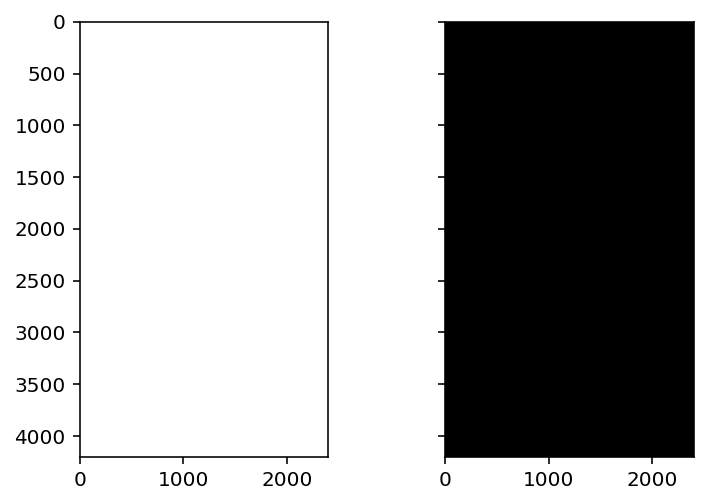

In [90]:
# test inverting black-is-min image with Pillow then just change EXIF tag for 
# Photometric_Interpretation to white-is-min since Pillow does not have
# the capability to save with this setting because black-is-min (value of 1)
# is hard-coded into the Pillow Sourcecode!

test_bitonal_image_path = bitonal_df['SourceFile'][1]
photometric_interpretation = !magick {test_bitonal_image_path} -format "%[tiff:photometric]" info:
print(f'Original Bitonal Image: {photometric_interpretation}')
image_array = np.array(Image.open(test_bitonal_image_path))
image = Image.fromarray(image_array)
image_array_inverted = np.invert(image_array)
image_inverted = Image.fromarray(image_array_inverted)
    f, axarr = plt.subplots(1, 2, sharey=True)
    axarr[0].imshow(image)
    axarr[1].imshow(image_inverted)
image_inverted.save('test.tif', compression='group4', dpi=(600., 600.))
photometric_interpretation = !magick {'test.tif'} -format "%[tiff:photometric]" info:
print(f'Inverted with numpy and saved with Pillow: {photometric_interpretation}')
!exiftool -n -PhotometricInterpretation=0 test.tif
photometric_interpretation = !magick {'test.tif'} -format "%[tiff:photometric]" info:
print(f'Test change metadata with ExifTool: {photometric_interpretation}')

{'compression': 'group4', 'dpi': (600.0, 600.0)}


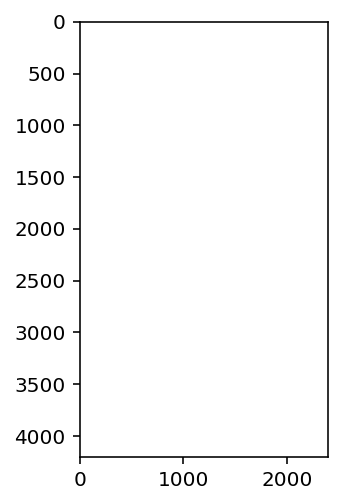

In [93]:
image_test = Image.open('test.tif')
print(image_test.info)
plt.imshow(image_test)

In [94]:
!exiftool -a -G1 -s {test_bitonal_image_path}

[ExifTool]      ExifToolVersion                 : 10.93
[System]        FileName                        : 00000002.tif
[System]        Directory                       : data/000000000001
[System]        FileSize                        : 1232 bytes
[System]        FileModifyDate                  : 2018:08:02 12:23:16-05:00
[System]        FileAccessDate                  : 2019:01:01 11:51:56-06:00
[System]        FileInodeChangeDate             : 2019:01:01 11:47:59-06:00
[System]        FilePermissions                 : rwxrwx---
[File]          FileType                        : TIFF
[File]          FileTypeExtension               : tif
[File]          MIMEType                        : image/tiff
[File]          ExifByteOrder                   : Little-endian (Intel, II)
[IFD0]          ImageWidth                      : 2400
[IFD0]          ImageHeight                     : 4200
[IFD0]          BitsPerSample                   : 1
[IFD0]          Compression                     : T6/Gro

In [99]:
!exiftool -a -G1 -s test.tif

[ExifTool]      ExifToolVersion                 : 10.93
[System]        FileName                        : test.tif
[System]        Directory                       : .
[System]        FileSize                        : 702 bytes
[System]        FileModifyDate                  : 2019:01:01 11:51:36-06:00
[System]        FileAccessDate                  : 2019:01:01 11:52:38-06:00
[System]        FileInodeChangeDate             : 2019:01:01 11:51:36-06:00
[System]        FilePermissions                 : rw-r--r--
[File]          FileType                        : TIFF
[File]          FileTypeExtension               : tif
[File]          MIMEType                        : image/tiff
[File]          ExifByteOrder                   : Little-endian (Intel, II)
[IFD0]          ImageWidth                      : 2400
[IFD0]          ImageHeight                     : 4200
[IFD0]          BitsPerSample                   : 1
[IFD0]          Compression                     : T6/Group 4 Fax
[IFD0]      

In [ ]:
stub = 'BOR-Reports_Minute-Book-67_'
number_of_images = 60
for number in range(number_of_images):
    number += 1  # start renumbering names with 1, not 0!
    if number % 2 == 0:  # only process odd numbers
        new_filename = stub + str(number).zfill(4) + '.tif'
        new_path = Path(image_directory).parents[0].joinpath(new_filename)
        print(new_path)

# Contone ToDo
## Need to verify contone images then process into JPEG2000

In [45]:
# TODO:

# Process grayscale and color separately
# split into grayscale/color

# need to verify: resolution 

# Tesseract OCR and hOCR creation (then convert hOCR to XML)

In [ ]:
# get ocr .hocr
!tesseract {str(image_path)} {str(text_output)} -l eng+spa hocr  # add hocr to end for location

In [ ]:
# get ocr .hocr
!tesseract {str(image_path)} {str(text_output)} -l eng+spa hocr  # add hocr to end for location

In [ ]:
# convert .hocr to .xml
hocr_path = Path(str(text_output) + '.hocr')
xml_path = Path(str(text_output) + '.xml')
hocr_path.rename(xml_path)

In [ ]:
# conversion to OOP

class HathiTrust_Volume:
    
    '''Common base class for all Hathi Trust Volumes'''
    
    def __init__(self, image_directory, object_id):
        self.image_directory_path = Path(image_directory)
        self.object_id = object_id
        
        
    def get_image_paths(self, with_extension):
        
        
        
        image_paths_list = sorted(self.image_directory_path.glob('*.tif'))  # only works with .tif images
        
        
    def report(self):
        '''
        Reports back with known list of errors and remediation suggestions
        '''
        error_list = []
        if self.image_directory_path.name != str(object_id):
            error_list.append('1. directory name and object ID do NOT match: MUST remediate')
        
            
        print(error_list)
            
image_directory = 'data/Reavis_Without_Documents/'
ht_volume = HathiTrust_Volume(image_directory, object_id)
ht_volume.report()    